## Calculate the TSN intrinsic value

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [2]:
#load data
path_data = '../input/TSN_Q_exp.csv'
data = pd.read_csv(path_data, sep=';', parse_dates=[2])
# filter data
report = 'Q'
# end date years ago
years = 0
# start date 7 year earlier than end date
start_date = pd.Timestamp(datetime.date.today()) - pd.Timedelta(days=(7*365) + (years*365))
end_date = pd.Timestamp(datetime.date.today()) - pd.Timedelta(days=years*365)

data_filt = data.loc[(data['report'] == report) & (data['date'] > start_date) & (data['date'] < end_date), :]
data_filt.reset_index(drop=True, inplace=True)

In [3]:
data_filt.head()

,ticker,report,date,rev,cost_sale,r_d,sale_gen_adm,inpairm,other_charg,op_income,...,short_debt,acc_pay,other_curr_liab,tot_curr_liab,tot_long_debt,other_liab,tot_equity,tot_liab,depr_amort,stock_b_comp
0,TSN,Q,2016-10-01,9156,8067,0,503,0,0,586,...,79,1511,1172,2762,6200.0,1242,9624,12749,179,20.25
1,TSN,Q,2017-01-01,9182,7699,0,501,0,0,982,...,66,1591,1315,2972,5901.0,1279,9567,12690,177,23.00
2,TSN,Q,2017-04-01,9083,8036,0,476,0,0,571,...,543,1466,1097,3106,5905.0,1280,9789,12807,179,23.00
3,TSN,Q,2017-07-01,9850,8648,0,505,0,0,697,...,1017,1608,1217,3865,9807.0,1265,10137,17926,187,23.00
4,TSN,Q,2017-10-01,10145,8794,0,670,0,0,681,...,906,1698,1424,4032,9297.0,1199,10559,17507,218,23.00


### Calculate EBITDA, EBIT, NOPAT, CAPEX etc on hisorical data

In [4]:
def calculate_missing_columns(df):
    df['ebitda'] = df['rev'] - df['cost_sale'] - df['sale_gen_adm'] - df['r_d'] - df['other_charg']
    df['ebit'] = df['ebitda'] - df['depr_amort']
    df['nopat'] = df['ebit'] - df['inc_tax_exp']
    df['other_curr_ass_lesscash'] = df['acc_rec'] + df['invent'] + df['other_curr_ass']
    df['tot_curr_liab_lessdebt'] = df['tot_curr_liab'] - df['short_debt']
    df['nwc'] = df['other_curr_ass_lesscash'] - df['tot_curr_liab_lessdebt']
    # capex calculation
    capex = []
    for index in range(len(df)):
        if index > 0:
            ppe_change = df['ppe_net'].iloc[index] - df['ppe_net'].iloc[index-1]
            depr_amort = df['depr_amort'].iloc[index]
            capex.append(ppe_change + depr_amort)
        else:
            capex.append(np.nan)
    df.loc[:, 'capex'] = capex

    return df

In [5]:
data_filt = calculate_missing_columns(data_filt)
data_filt.head()

/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_6064/3706664529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ebitda'] = df['rev'] - df['cost_sale'] - df['sale_gen_adm'] - df['r_d'] - df['other_charg']
/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_6064/3706664529.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ebit'] = df['ebitda'] - df['depr_amort']
/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_6064/3706664529.py:4: SettingWithCopyWarning: 
A value is 

,ticker,report,date,rev,cost_sale,r_d,sale_gen_adm,inpairm,other_charg,op_income,...,tot_liab,depr_amort,stock_b_comp,ebitda,ebit,nopat,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,capex
0,TSN,Q,2016-10-01,9156,8067,0,503,0,0,586,...,12749,179,20.25,586,407,268,4539,2683,1856,NaN
1,TSN,Q,2017-01-01,9182,7699,0,501,0,0,982,...,12690,177,23.00,982,805,487,4435,2906,1529,213.0
2,TSN,Q,2017-04-01,9083,8036,0,476,0,0,571,...,12807,179,23.00,571,392,214,4774,2563,2211,256.0
3,TSN,Q,2017-07-01,9850,8648,0,505,0,0,697,...,17926,187,23.00,697,510,341,5196,2848,2348,449.0
4,TSN,Q,2017-10-01,10145,8794,0,670,0,0,681,...,17507,218,23.00,681,463,278,5133,3126,2007,241.0


### 2.1. Forecast Revenue

Before the ARIMA / SARIMA modling need to know p, d, q values (model parameters):
- p: Trend autoregression order.
- q: Trend moving average order.
- d: Trend difference order.

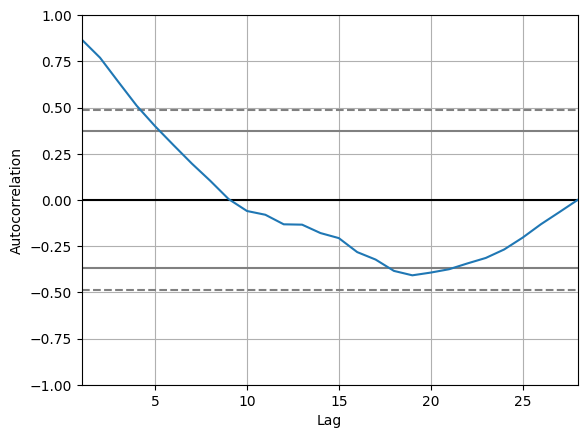

In [6]:
# Creating Autocorrelation plot - ACF
x = pd.plotting.autocorrelation_plot(data_filt['rev'])
x.plot()
plt.show()

The monotony of ACF is changed first time there is the p value. 

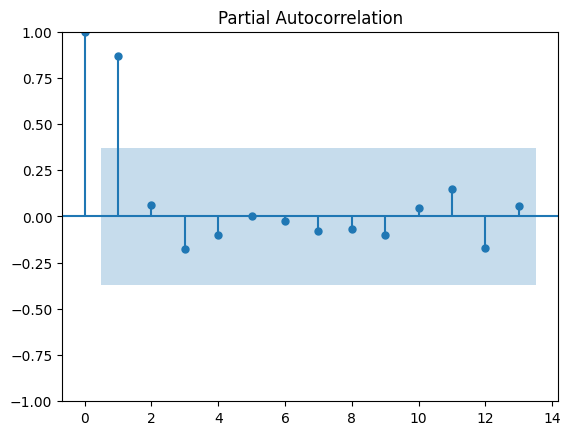

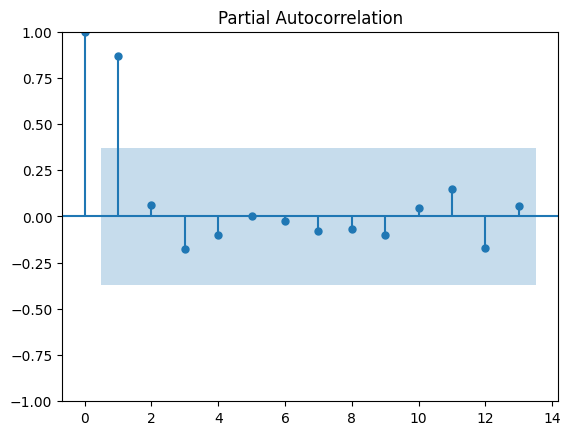

In [7]:
# Creating Partial Autocorrelation plot --> PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_filt['rev'], lags = 13)

Number of points, which are far away from the boundary is the q value.

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how a decide the q value. Hence the value of q is 2.

The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

I will find ARIMA hyperparameters (p, d, q) with gridsearch step-by-step

In [8]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    print(error)
    return error

In [9]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [10]:
# evaluate an ARIMA model for a given order (p,d,q) ---> You can tip p and estimate d, q based on previous plots
series = data_filt['rev']
# evaluate parameters
p_values = [2, 4, 6, 8, 10, 12]
d_values = [1]
q_values = [1, 2, 3]
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

319308.9538501059
ARIMA(2, 1, 1) MSE=319308.954
280141.247133646
ARIMA(2, 1, 2) MSE=280141.247
408385.5703613299
ARIMA(2, 1, 3) MSE=408385.570
330589.7557919711
ARIMA(4, 1, 1) MSE=330589.756
411936.4789912712
ARIMA(4, 1, 2) MSE=411936.479
357923.3031949821
ARIMA(4, 1, 3) MSE=357923.303
436264.61409319396
ARIMA(6, 1, 1) MSE=436264.614
340127.58516257536
ARIMA(6, 1, 2) MSE=340127.585
385445.1128317635
ARIMA(8, 1, 1) MSE=385445.113
375421.89660459134
ARIMA(8, 1, 2) MSE=375421.897
1010658.1030409873
ARIMA(8, 1, 3) MSE=1010658.103
5054369661.442976
ARIMA(12, 1, 1) MSE=5054369661.443
2547913.6335770884
ARIMA(12, 1, 2) MSE=2547913.634
Best ARIMA(2, 1, 2) MSE=280141.247


The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model.

The parameter "s" is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect. Here is hardcoded, works well with 12.

In [11]:
# float datatype is needed to SARIMAX model
data_filt['rev'] = data_filt['rev'].astype(float)

In [12]:
# use the model parameters of SARIMA
p, d, q = 2, 1, 1
model=sm.tsa.statespace.SARIMAX(data_filt['rev'].values,
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32585D+00    |proj g|=  1.78156D-01

At iterate    5    f=  4.27491D+00    |proj g|=  6.01124D-02

At iterate   10    f=  4.26260D+00    |proj g|=  1.98732D-02

At iterate   15    f=  4.25999D+00    |proj g|=  1.41898D-03


 This problem is unconstrained.



At iterate   20    f=  4.25983D+00    |proj g|=  9.23124D-04

At iterate   25    f=  4.25982D+00    |proj g|=  1.25332D-04

At iterate   30    f=  4.25982D+00    |proj g|=  2.51977D-03

At iterate   35    f=  4.25904D+00    |proj g|=  2.08105D-02

At iterate   40    f=  4.25220D+00    |proj g|=  3.05340D-02

At iterate   45    f=  4.24229D+00    |proj g|=  1.77891D-02

At iterate   50    f=  4.23894D+00    |proj g|=  9.91923D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   9.919D-03   4.239D+00
  F =   4.2389400870091807     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

In [13]:
period = 20
# use SARIMAX model
prediction_revenue = model.predict(len(data_filt), len(data_filt) + period)
# df from results
prediction = pd.DataFrame(
    prediction_revenue,
    index=[i+1 for i in range(len(prediction_revenue))],
    columns=['rev']
)

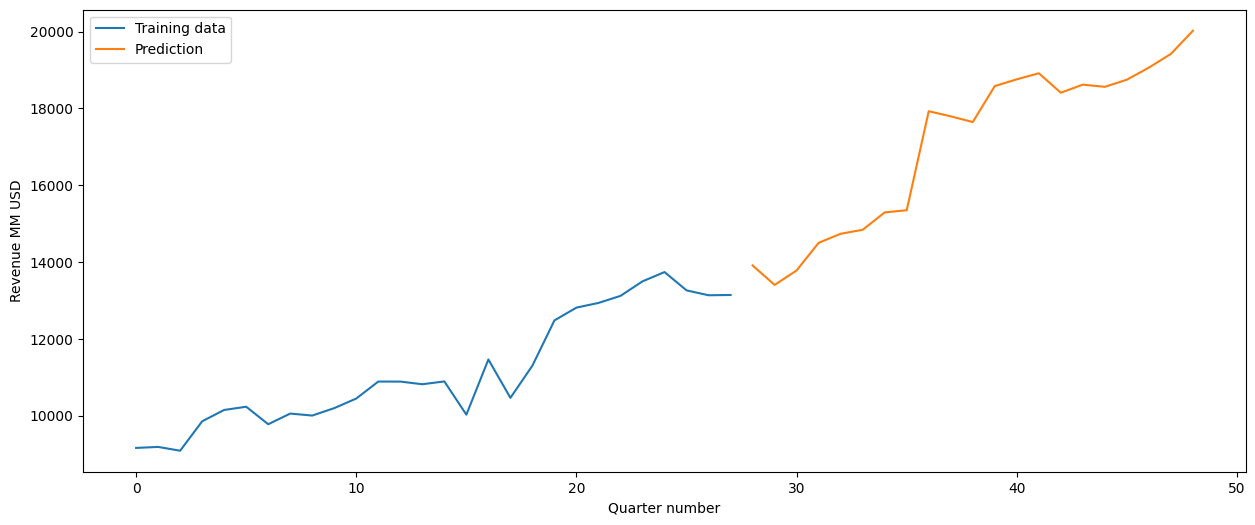

In [14]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(data_filt['rev'].index, data_filt['rev'].values, label='Training data')
ax1.plot(prediction.index+len(data_filt)-1, prediction['rev'], label='Prediction')

ax1.set_xlabel('Quarter number')
ax1.set_ylabel('Revenue MM USD')

plt.legend()
plt.show()

### 2.2. Calculate ratios

After the revenue prediction I calculate the expenses and use those to predict future CoS and EBITDA.

In [15]:
# create a function to calculate ratios
def calculate_margins(df):
    is_incomes = ['cost_sale', 'sale_gen_adm', 'r_d', 'other_charg']
    calc_margins = dict()
    # plot and calculate ratios
    for income in is_incomes:
        if income != 'inc_tax_exp':
            div = 'rev'
        else:
            div = 'inc_b_tax'

        fig, ax1 = plt.subplots(figsize=(15, 6))

        ax1.plot(df['date'], df[income]/df[div], label=income.replace('_', ' ').upper())
        ax1.axhline(y=(df[income]/df[div]).mean(), color='r', label='Average value')
        
        ax1.set_xlabel('Date')
        ax1.set_ylabel(income.replace('_', ' ').upper())
        
        plt.legend()
        plt.show()

        calc_margins[income+'_margin'] = (df[income]/df[div]).mean()

        print(str(income)+' is divided by the revenue.')
        print('Average value: '+str((df[income]/df[div]).mean()))

    return calc_margins

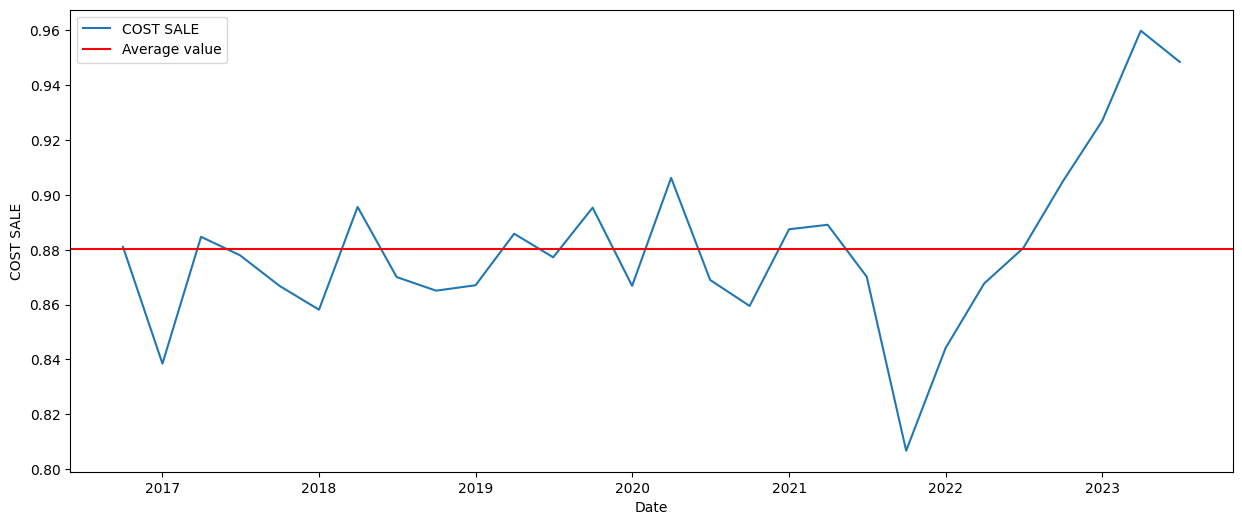

cost_sale is divided by the revenue.
Average value: 0.8804059223302635


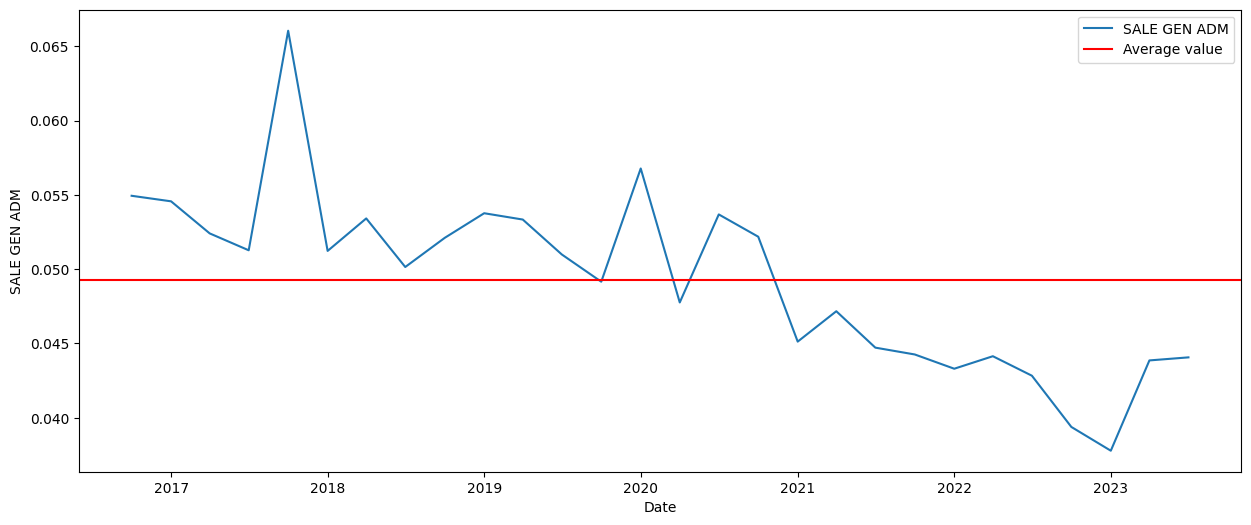

sale_gen_adm is divided by the revenue.
Average value: 0.04929904938104224


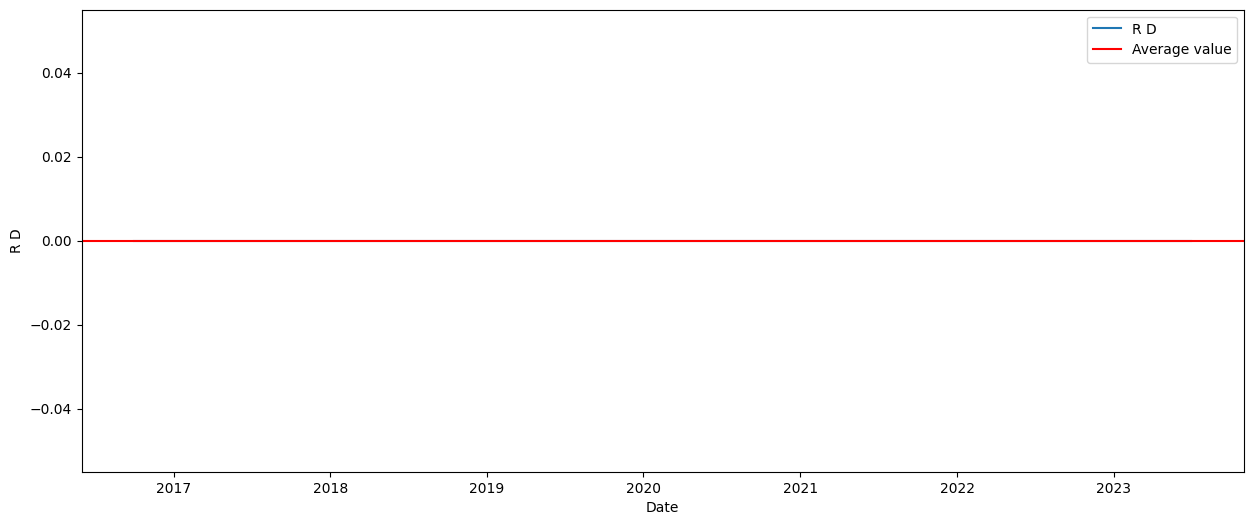

r_d is divided by the revenue.
Average value: 0.0


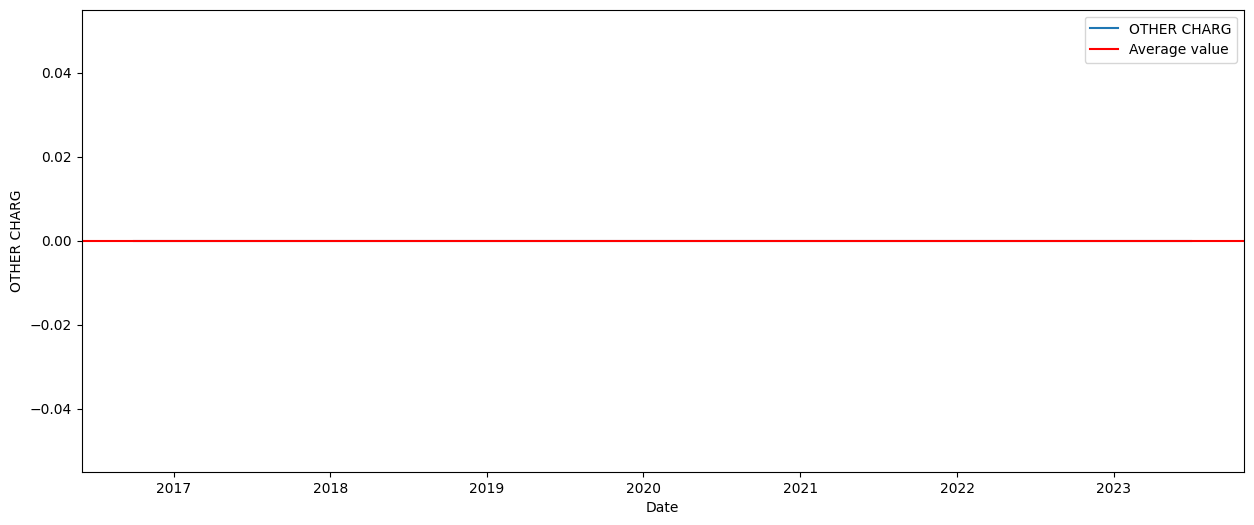

other_charg is divided by the revenue.
Average value: 0.0


In [16]:
base_case = calculate_margins(data_filt)

In [17]:
#prediction['ebit'] = prediction['ebitda'] - prediction['depr_amort']
for column in ['cost_sale', 'sale_gen_adm', 'r_d', 'other_charg']:
    prediction[column] = prediction['rev'] * base_case[column+'_margin']

prediction.tail()

,rev,cost_sale,sale_gen_adm,r_d,other_charg
17,18562.766996,16342.769998,915.126767,0.0,0.0
18,18748.490216,16506.281821,924.282745,0.0,0.0
19,19063.211883,16783.364640,939.798224,0.0,0.0
20,19420.532157,17097.951526,957.413774,0.0,0.0
21,20024.063923,17629.304467,987.167316,0.0,0.0


## 2.3. Calculate Fixed Assets

It's time to calculate D&A costs.

I will predict the PPE, D&A and CapEx values together.

In [18]:
# fixed asset sliced dataframe
fixed_asset = data_filt.loc[:, ['ppe_net', 'depr_amort']]
# calculate PPE start & CAPEX
fixed_asset['ppe_net_start'] = [fixed_asset['ppe_net'].values[i-1] if i > 0 else np.nan for i in range(len(fixed_asset['ppe_net'].values))]
fixed_asset['capex'] = fixed_asset['ppe_net'] - fixed_asset['ppe_net_start'] + fixed_asset['depr_amort']

fixed_asset.head()

,ppe_net,depr_amort,ppe_net_start,capex
0,5170,179,NaN,NaN
1,5206,177,5170.0,213.0
2,5283,179,5206.0,256.0
3,5545,187,5283.0,449.0
4,5568,218,5545.0,241.0


In [19]:
def fixed_asset_ratios():
    fixed_asset_ratios = dict()
    # D&A ratio
    for column in ['depr_amort', 'capex']:
        ratio = fixed_asset[column]/fixed_asset['ppe_net_start']
        ratio.hist()
        plt.show()
        fixed_asset_ratios[column+'_ratio'] = ratio.mean()
        print('Average', column, 'value is', fixed_asset_ratios[column+'_ratio'])
    return fixed_asset_ratios

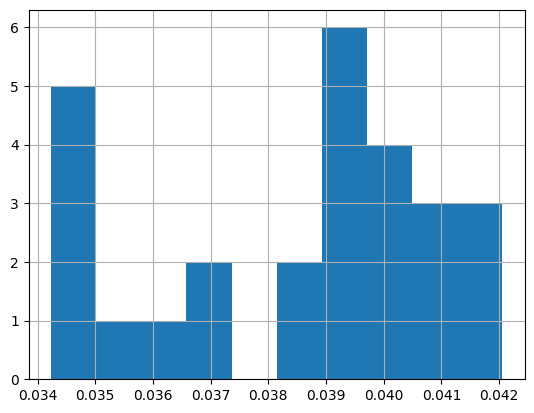

Average depr_amort value is 0.03848667347816388


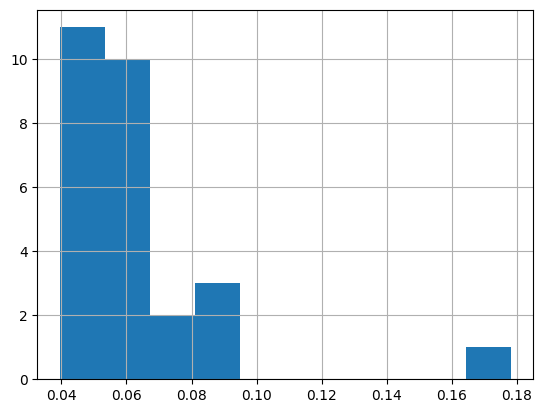

Average capex value is 0.06203405858961153


In [20]:
fxd_ass_ratios = fixed_asset_ratios()

In [21]:
def predict_fixed_assets(raw_df, prediction_df, fxd_ass_ratios):
    # get the last measured PPE as start in case of prediction
    ppe_start_pred = [raw_df['ppe_net'].iloc[-1]]
    depr_amort_pred = []
    capex_pred = []
    ppe_net = []
    # calculate prediction
    for index in range(len(prediction_df)):
        depr_amort_pred.append(ppe_start_pred[-1] * fxd_ass_ratios['depr_amort_ratio'])
        capex_pred.append(ppe_start_pred[-1] * fxd_ass_ratios['capex_ratio'])
        ppe_net.append(ppe_start_pred[-1] - depr_amort_pred[-1] + capex_pred[-1])
        # add the last PPE as starting to the PPE start
        ppe_start_pred.append(ppe_net[-1])
    
    prediction_df['depr_amort'] = depr_amort_pred
    prediction_df['capex'] = capex_pred
    prediction_df['ppe_net'] = ppe_net

    return prediction_df

In [22]:
prediction = predict_fixed_assets(data_filt, prediction, fxd_ass_ratios)
prediction.head()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net
1,13909.652846,12246.140743,685.732663,0.0,0.0,369.933905,596.271371,9838.337466
2,13402.522702,11799.660361,660.731629,0.0,0.0,378.644882,610.312003,10070.004587
3,13779.779252,12131.799262,679.330018,0.0,0.0,387.560978,624.683255,10307.126863
4,14498.923762,12764.938348,714.783159,0.0,0.0,396.687026,639.392912,10549.832749
5,14734.782986,12972.590205,726.410794,0.0,0.0,406.027968,654.448943,10798.253723


## 2.4. Calculate EBITDA, EBIT, NOPAT

In [23]:
def calc_eff_tax_rate(df):
    if df['date'].iloc[-1] > pd.Timestamp('2017-01-01'):
        eff_tax_rate = 0.21
    else:
        eff_tax_rate = (data_filt['inc_tax_exp']/data_filt['ebit']).mean()
        # plot
        (data_filt['inc_tax_exp']/data_filt['ebit']).hist(range=[0, 1])
        plt.show()

    print('Effective tax rate is', eff_tax_rate)
    return eff_tax_rate

eff_tax_rate = calc_eff_tax_rate(data_filt)

Effective tax rate is 0.21


In [24]:
def calculate_ebitda_ebit_nopat(prediction_df, eff_tax_rate):
    # if R&D or Other expenses missing itt will add nan, must to replace nan with 0
    prediction_df['r_d'] = prediction_df['r_d'].fillna(0.0)
    prediction_df['other_charg'] = prediction_df['other_charg'].fillna(0.0)
    prediction_df['ebitda'] = prediction_df['rev'] - prediction_df['cost_sale'] - prediction_df['sale_gen_adm'] - prediction_df['r_d'] - prediction_df['other_charg']
    prediction_df['ebit'] = prediction_df['ebitda'] - prediction_df['depr_amort']
    prediction_df['nopat'] = prediction_df['ebit'] - (prediction_df['ebit'] * eff_tax_rate)
    return prediction_df

In [25]:
prediction = calculate_ebitda_ebit_nopat(prediction, eff_tax_rate)
prediction.head()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net,ebitda,ebit,nopat
1,13909.652846,12246.140743,685.732663,0.0,0.0,369.933905,596.271371,9838.337466,977.779440,607.845535,480.197972
2,13402.522702,11799.660361,660.731629,0.0,0.0,378.644882,610.312003,10070.004587,942.130712,563.485831,445.153806
3,13779.779252,12131.799262,679.330018,0.0,0.0,387.560978,624.683255,10307.126863,968.649972,581.088994,459.060305
4,14498.923762,12764.938348,714.783159,0.0,0.0,396.687026,639.392912,10549.832749,1019.202256,622.515230,491.787032
5,14734.782986,12972.590205,726.410794,0.0,0.0,406.027968,654.448943,10798.253723,1035.781987,629.754019,497.505675


## 2.5. Function to plot Prediction vs Historical data

In [52]:
def plot_hist_pred(hist_df, pred_df):
    # reset index
    prediction.index = [i for i in range(len(hist_df), len(hist_df) + len(pred_df))]
    
    for column in pred_df.columns:
        try:
            fig, ax1 = plt.subplots(figsize=(15, 6))

            ax1.plot(hist_df.index, hist_df[column], color='k', label='Historical data')
            ax1.plot(pred_df.index, pred_df[column], color='r', label='Predicted values')

            ax1.set_xlabel('Index')
            ax1.set_ylabel(column.replace('_', ' ').upper())

            plt.legend()
            plt.show()
        except:
            continue

## 2.6. Calculate Net Working Capital

To get this we have to forecast the current assets and liabilities.
I will use ratios to predict them:
- Days Sales Outstanding (dso) --> (Account recivable / Revenue) * 360
- Days Inventory Outstanding (dio) --> (Inventory / Cost of General Sale) * 360
- Other current assets per revenue (oca_rev) --> Other current assets / revenue
- Current liabilities per revenue (tcl_rec) --> (Total current liabilities - current debt) / revenue

In [27]:
nwc = data_filt.loc[:, ['rev', 'cost_sale', 'cash_cash_eq', 'acc_rec', 'invent', 'other_curr_ass', 'tot_curr_ass', 'acc_pay', 'short_debt', 'tot_curr_liab']]

In [28]:
def calculate_nwc_ratios(df):
    result = dict()
    # Days Sales Outstanding (dso)
    dso = (df['acc_rec'] / df['rev']) * 360
    dso.hist()
    plt.show()
    result['dso'] = dso.mean()
    print('DSO:', result['dso'])

    #Days Inventory Out. (dis)
    dio = (df['invent'] / df['cost_sale']) * 360
    dio.hist()
    plt.show()
    result['dio'] = dio.mean()
    print('DIO:', result['dio'])

    #Days Payable Out. (dpo)
    dpo = (df['acc_pay'] / df['cost_sale']) * 360
    dpo.hist()
    plt.show()
    result['dpo'] = dpo.mean()
    print('DPO:', result['dpo'])


    #Sum of Other current assets per revenue --> soca_rev
    # calculate the non cach non accoint recivable and inventory total current assets ratio to revenue
    soca_rev = (df['tot_curr_ass'] - df['acc_rec'] - df['invent'] - df['cash_cash_eq']) / df['rev']
    soca_rev.hist()
    plt.show()
    result['soca_rev'] = soca_rev.mean()
    print('Sum Other Current Assets:', result['soca_rev'])

    #Sum of Other current liabilities per revenue --> socl_rev
    # calculate the non current debt non account payable total current liabilities ratio to revenue
    socl_rev = (df['tot_curr_liab'] - df['short_debt'] - df['acc_pay']) / df['rev']
    socl_rev.hist()
    plt.show()
    result['socl_rev'] = socl_rev.mean()
    print('Sum Other Current Liabilities per Rec', result['socl_rev'])
    
    return result

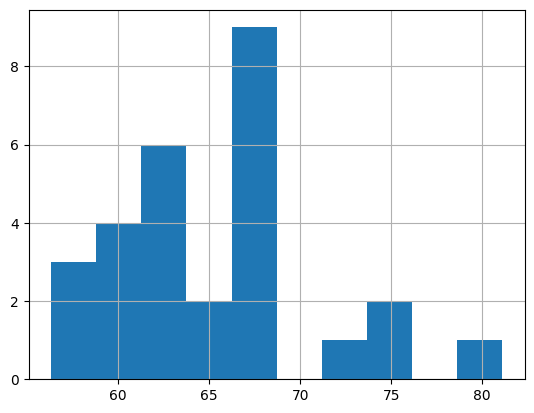

DSO: 65.21896241425601


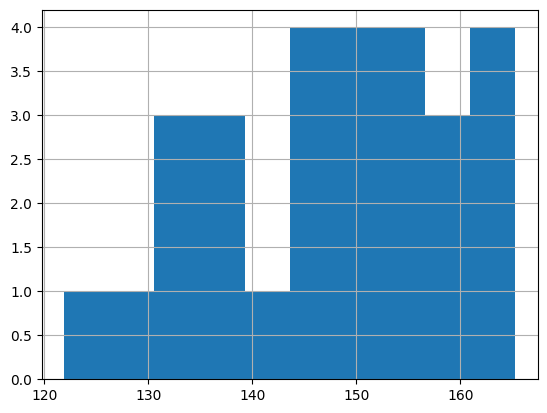

DIO: 147.9153001615359


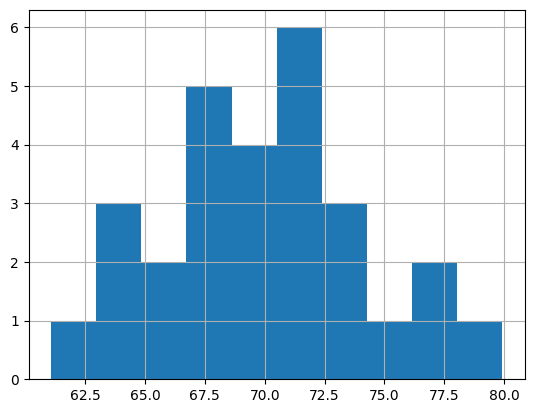

DPO: 70.1136863685535


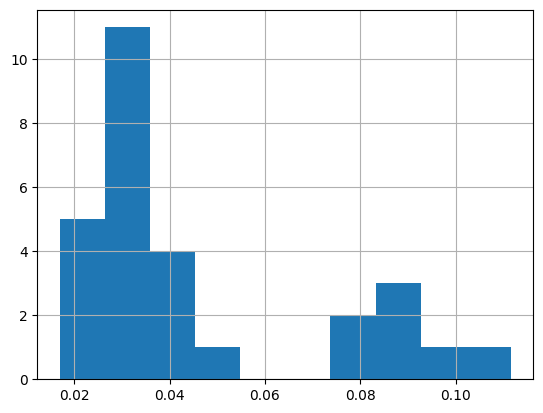

Sum Other Current Assets: 0.04607856716562208


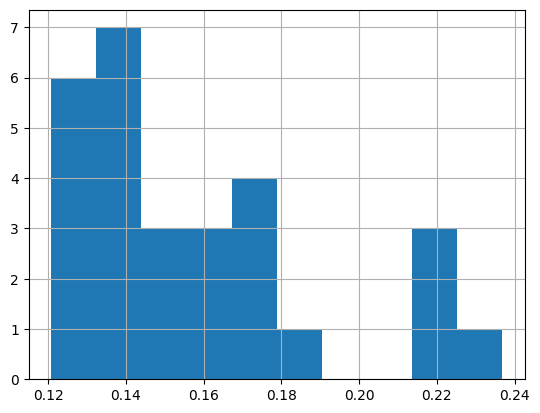

Sum Other Current Liabilities per Rec 0.15830185081718245


In [29]:
nwc_ratios = calculate_nwc_ratios(nwc)

In [30]:
def predict_curr_ass_liab(df_prediction, nwc_ratios):
    # calculate assets, liabilities, and net working capital from NWC ratio
    df_prediction['acc_rec'] = (df_prediction['rev'] * nwc_ratios['dso']) / 360
    df_prediction['invent'] = (df_prediction['cost_sale'] * nwc_ratios['dio']) / 360
    df_prediction['acc_pay'] = (df_prediction['cost_sale'] * nwc_ratios['dpo']) / 360
    
    df_prediction['other_curr_ass_lesscash'] = df_prediction['acc_rec'] + df_prediction['invent'] + (df_prediction['rev'] * nwc_ratios['soca_rev'])
    df_prediction['tot_curr_liab_lessdebt'] = df_prediction['acc_pay'] + (df_prediction['rev'] * nwc_ratios['socl_rev'])
    df_prediction['nwc'] = df_prediction['other_curr_ass_lesscash'] - df_prediction['tot_curr_liab_lessdebt']
    return df_prediction

In [31]:
prediction = predict_curr_ass_liab(prediction, nwc_ratios)
prediction.head()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net,ebitda,ebit,nopat,acc_rec,invent,acc_pay,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc
1,13909.652846,12246.140743,685.732663,0.0,0.0,369.933905,596.271371,9838.337466,977.779440,607.845535,480.197972,2519.925350,5031.643288,2385.061309,8192.505512,4586.985099,3605.520413
2,13402.522702,11799.660361,660.731629,0.0,0.0,378.644882,610.312003,10070.004587,942.130712,563.485831,445.153806,2428.051734,4848.195289,2298.104683,7893.816066,4419.748832,3474.067234
3,13779.779252,12131.799262,679.330018,0.0,0.0,387.560978,624.683255,10307.126863,968.649972,581.088994,459.060305,2496.396959,4984.663137,2362.792135,8116.012580,4544.156694,3571.855885
4,14498.923762,12764.938348,714.783159,0.0,0.0,396.687026,639.392912,10549.832749,1019.202256,622.515230,491.787032,2626.679900,5244.804687,2486.102455,8539.574219,4781.308922,3758.265297
5,14734.782986,12972.590205,726.410794,0.0,0.0,406.027968,654.448943,10798.253723,1035.781987,629.754019,497.505675,2669.409049,5330.123817,2526.544781,8678.490554,4859.088199,3819.402355


## 2.7. Change in NWC

In [32]:
def calc_change_nwc(df_hist, df_predict):
    c_nwc = []
    
    if df_hist.equals(df_predict):
        for index in range(len(df_predict)):
            if index > 0:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_predict['nwc'].iloc[index-1])
            else:
                c_nwc.append(np.nan)
    else:
        for index in range(len(df_predict)):
            if index > 0:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_predict['nwc'].iloc[index-1])
            else:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_hist['nwc'].iloc[-1])
    
    df_predict['c_nwc'] = c_nwc
    
    return df_predict

In [33]:
prediction = calc_change_nwc(data_filt, prediction)
data_filt = calc_change_nwc(data_filt, data_filt)

In [34]:
def calc_unleveared_fcf(df):
    df['unlev_fcf'] = df['nopat'] + df['depr_amort'] - df['capex'] - df['c_nwc']
    return df

In [35]:
prediction = calc_unleveared_fcf(prediction)
data_filt = calc_unleveared_fcf(data_filt)

## 2.8. Calculate Weighted Average Cost of Capital (WACC)

In [36]:
def calculate_wacc(df, share_price, eff_tax_rate, us_bond_10_yr, expected_return, beta):
    equity = (share_price * df['shares'].iloc[-1])
    debt = df['short_debt'].iloc[-1] + df['tot_long_debt'].iloc[-1]
    
    cost_of_debt = abs(df['int_exp'].iloc[-1]) / debt
    d_per_d_plus_e = debt / (debt + equity)
    after_tax_cost_of_debt = cost_of_debt * (1 - eff_tax_rate)

    risk_free_rate = us_bond_10_yr
    market_risk_premium = expected_return - risk_free_rate
    cost_of_equity = risk_free_rate + (beta * market_risk_premium)
    e_per_d_plus_e = equity / (debt + equity)
    
    wacc = (d_per_d_plus_e * after_tax_cost_of_debt) + (e_per_d_plus_e * cost_of_equity)
    return wacc

In [37]:
wacc = calculate_wacc(
    df=data_filt,
    share_price=54.5,
    eff_tax_rate=eff_tax_rate,
    us_bond_10_yr=0.0434,
    expected_return=0.1,
    beta=0.78)

print('Estimated WACC value:', wacc)

Estimated WACC value: 0.06148860881417539


## 2.9. Present value of FCF, Terminal Value & present value of TV

In [38]:
def calculate_present_value_fcf(df, report='Q'):
    if report == 'Q':
        multipl = 0.25
    else:
        multipl = 1
    # calculate present cahs flows
    df['pres_val_fcf'] = df['unlev_fcf']/((1+wacc)**(df.index*multipl))
    return df

In [39]:
prediction = calculate_present_value_fcf(prediction, report=0)
prediction.head()

,rev,cost_sale,sale_gen_adm,r_d,other_charg,depr_amort,capex,ppe_net,ebitda,ebit,nopat,acc_rec,invent,acc_pay,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,c_nwc,unlev_fcf,pres_val_fcf
1,13909.652846,12246.140743,685.732663,0.0,0.0,369.933905,596.271371,9838.337466,977.779440,607.845535,480.197972,2519.925350,5031.643288,2385.061309,8192.505512,4586.985099,3605.520413,-87.479587,341.340094,321.567364
2,13402.522702,11799.660361,660.731629,0.0,0.0,378.644882,610.312003,10070.004587,942.130712,563.485831,445.153806,2428.051734,4848.195289,2298.104683,7893.816066,4419.748832,3474.067234,-131.453179,344.939864,306.134808
3,13779.779252,12131.799262,679.330018,0.0,0.0,387.560978,624.683255,10307.126863,968.649972,581.088994,459.060305,2496.396959,4984.663137,2362.792135,8116.012580,4544.156694,3571.855885,97.788651,124.149378,103.800282
4,14498.923762,12764.938348,714.783159,0.0,0.0,396.687026,639.392912,10549.832749,1019.202256,622.515230,491.787032,2626.679900,5244.804687,2486.102455,8539.574219,4781.308922,3758.265297,186.409412,62.671734,49.364002
5,14734.782986,12972.590205,726.410794,0.0,0.0,406.027968,654.448943,10798.253723,1035.781987,629.754019,497.505675,2669.409049,5330.123817,2526.544781,8678.490554,4859.088199,3819.402355,61.137057,187.947643,139.463382


## 2.10. Terminal Value and present value of TV

I use the perpetuity growth model

In [40]:
def calculate_tv_prestv_enterp_val(df, industry_growth_rate):
    # Terminal Value
    tv = ((df['unlev_fcf'].iloc[-1] * (1 + industry_growth_rate))) / (wacc - industry_growth_rate)
    # present value of TV
    pres_value_tv = tv / (1 + wacc)**5
    
    return tv, pres_value_tv

In [41]:
tv, pres_value_tv = calculate_tv_prestv_enterp_val(prediction, 0.03)
pres_value_tv

3144.6406581485053

In [42]:
def calc_enterp_company_value(df_hist, df_pred, pres_value_tv):
    
    debt = df_hist['short_debt'].iloc[-1] + df_hist['tot_long_debt'].iloc[-1]
    
    if 'equity_minor_interest' in df_hist.columns:
        equity_minor_interest = df_hist['equity_minor_interest'].iloc[-1]
    else:
        equity_minor_interest = 0
    # Enterprise Values
    enterp_val = df_pred['pres_val_fcf'].sum() + pres_value_tv
    # Company Value
    comp_val = enterp_val + df_hist['cash_cash_eq'].iloc[-1] + df_hist['short_inv'].iloc[-1] - debt - equity_minor_interest
        
    return enterp_val, comp_val

In [43]:
enterp_val, equity_value = calc_enterp_company_value(data_filt, prediction, pres_value_tv)

In [44]:
def implied_share_price(equity_value, hist_df):
    share_price = equity_value / hist_df['shares'].iloc[-1]
    return share_price

In [45]:
fcst_share_price = implied_share_price(equity_value, data_filt)
print('Current realistic share price:', fcst_share_price)

Current realistic share price: -8.500785934809663


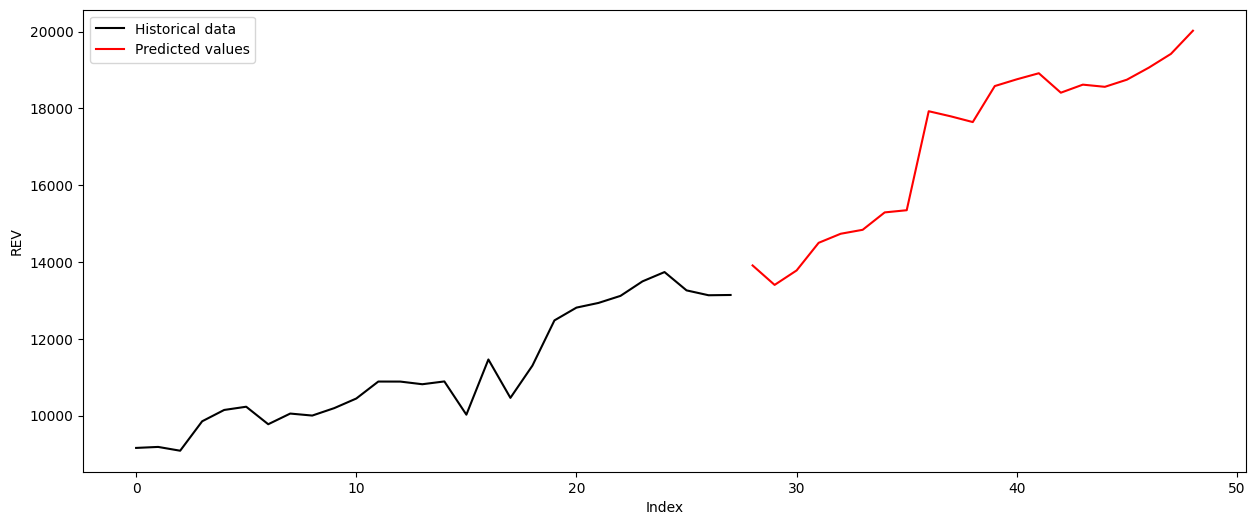

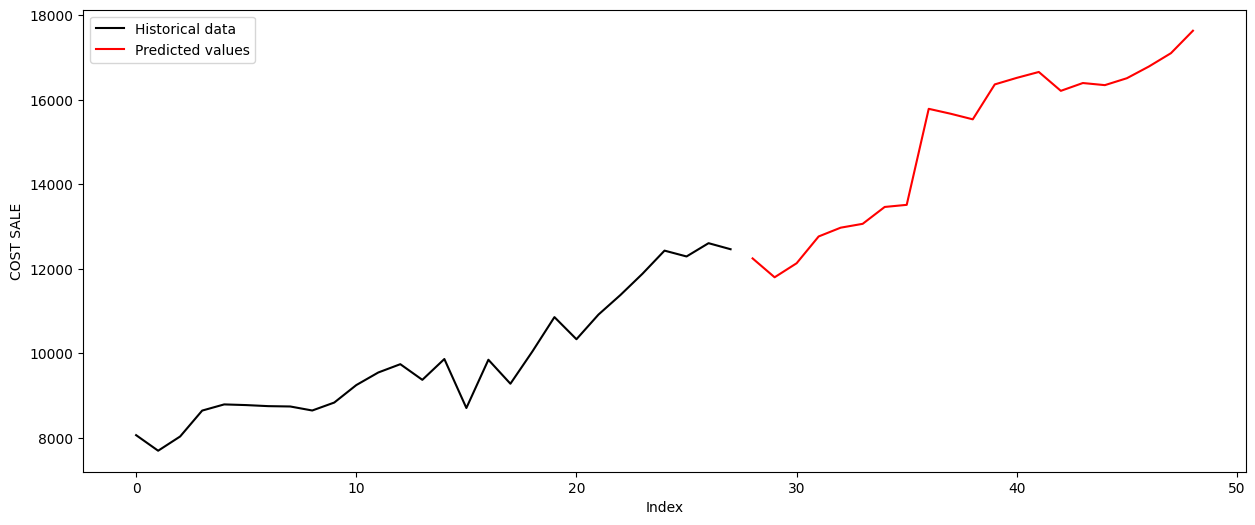

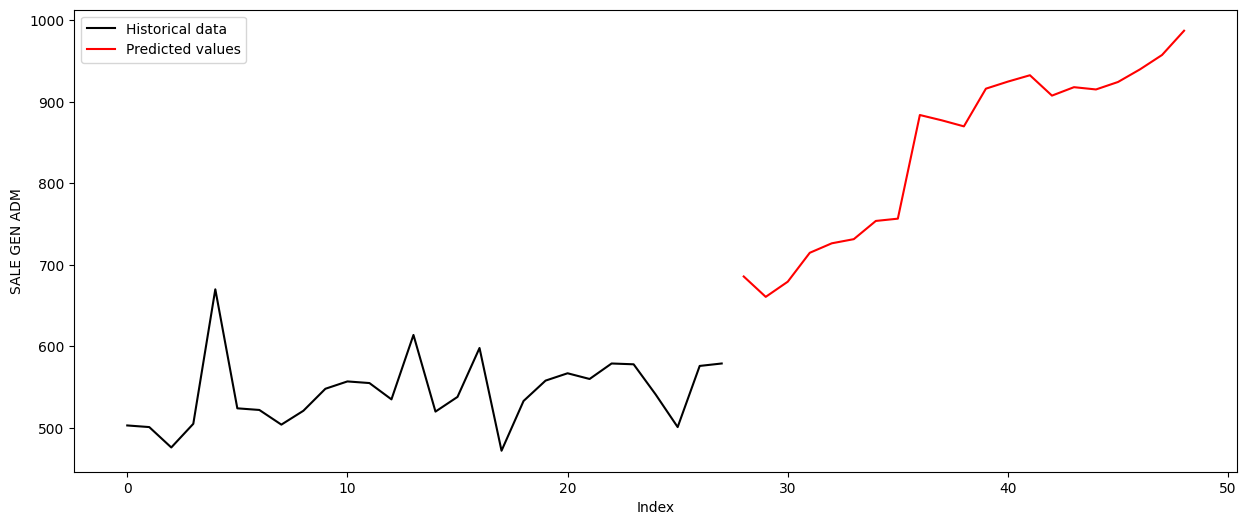

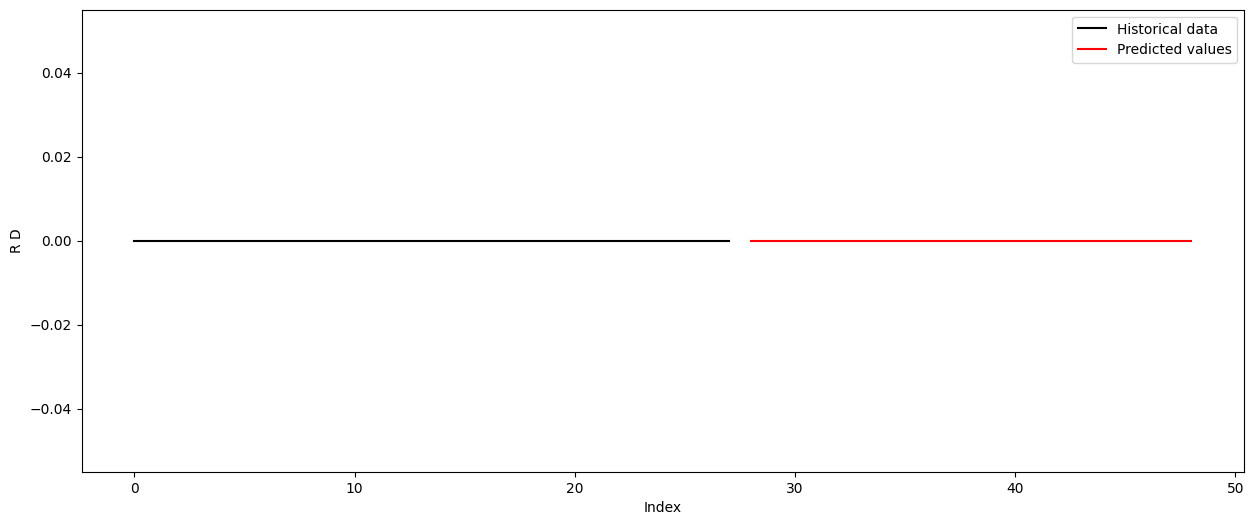

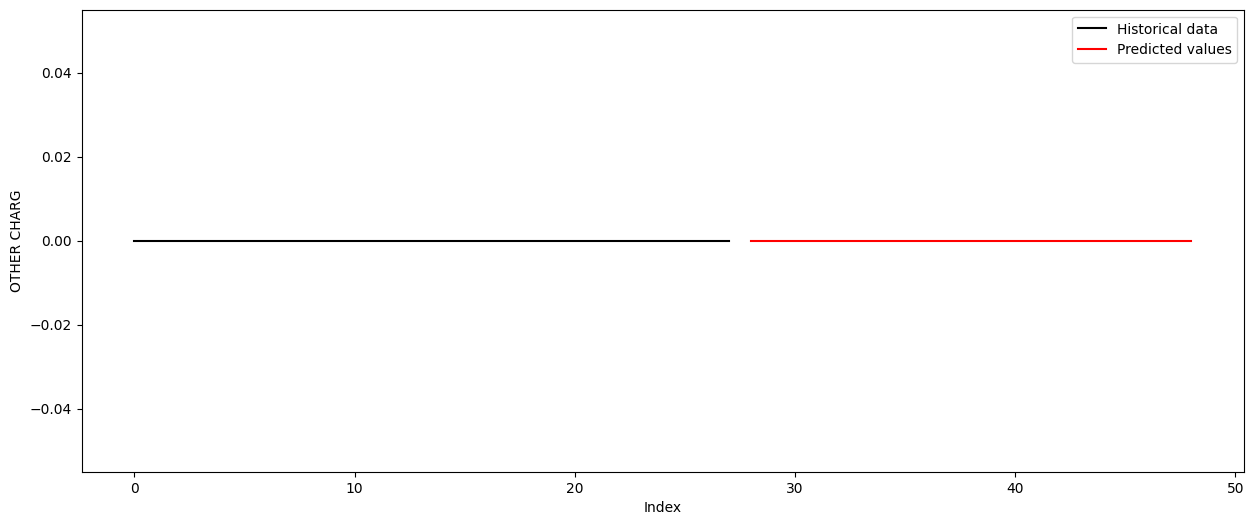

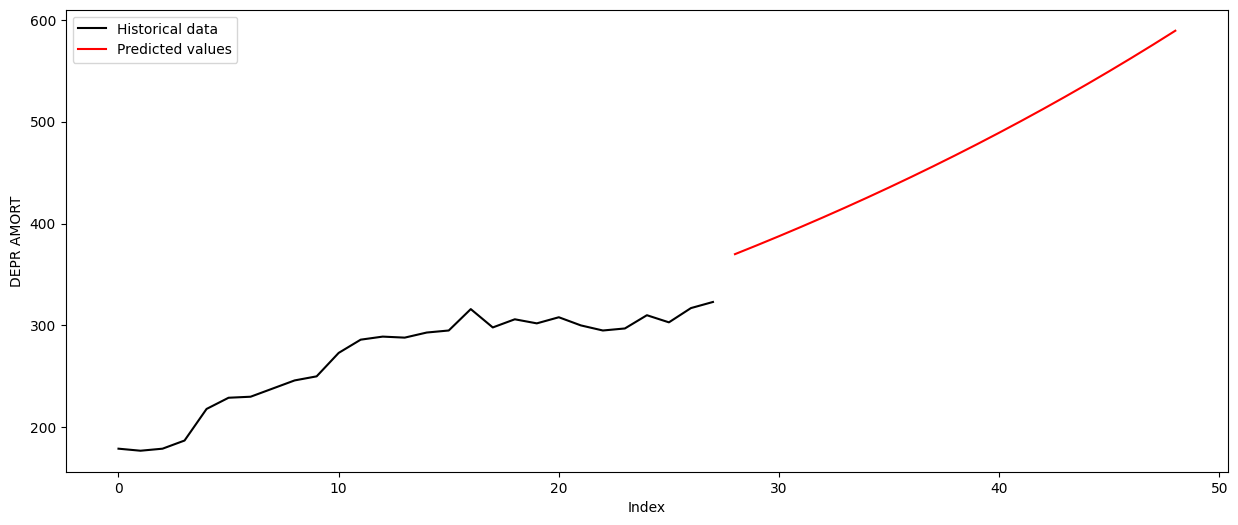

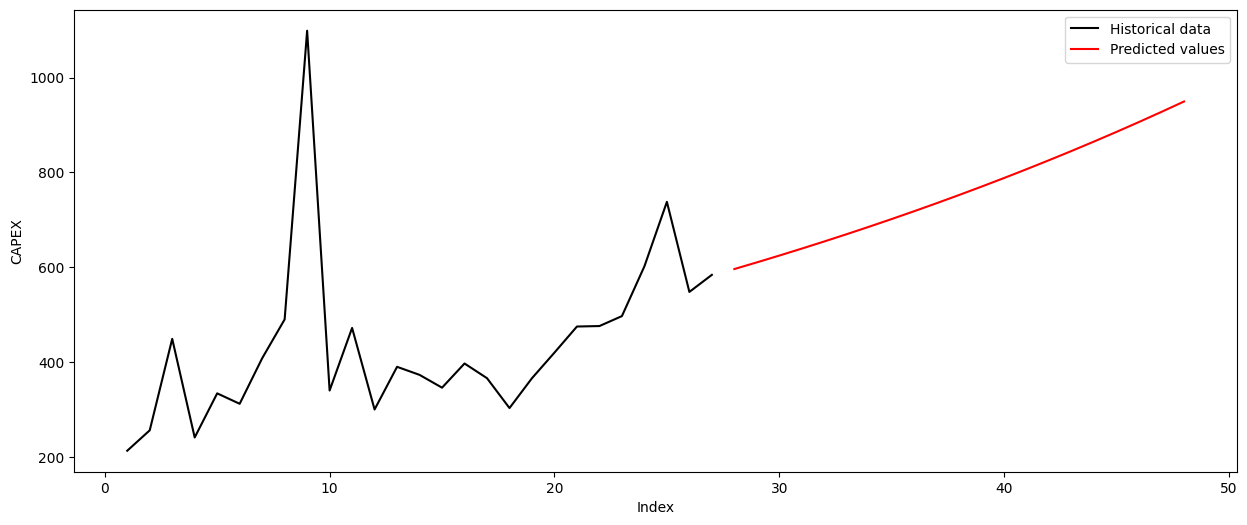

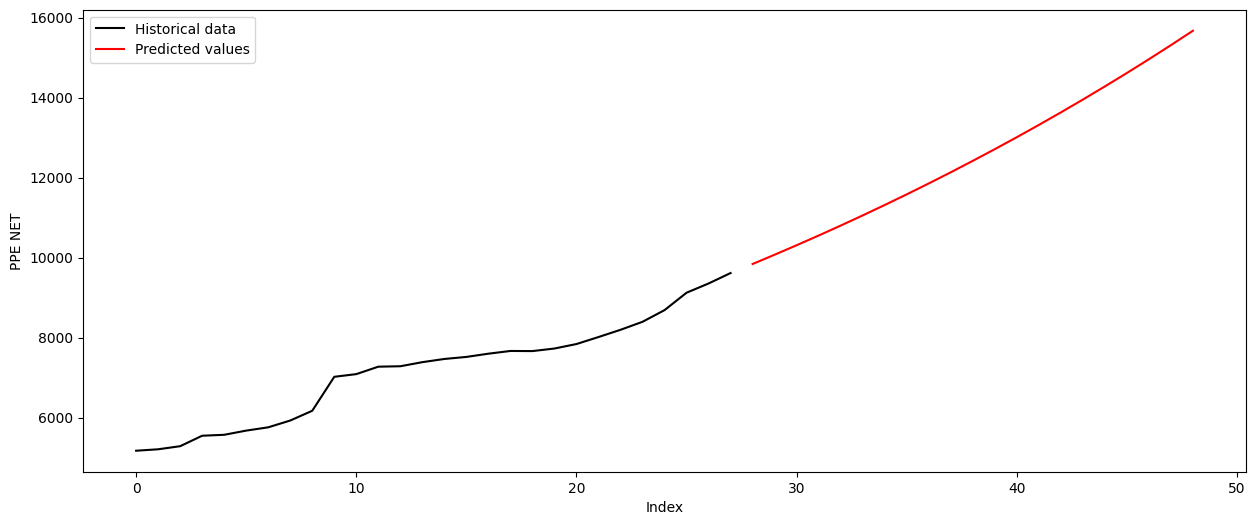

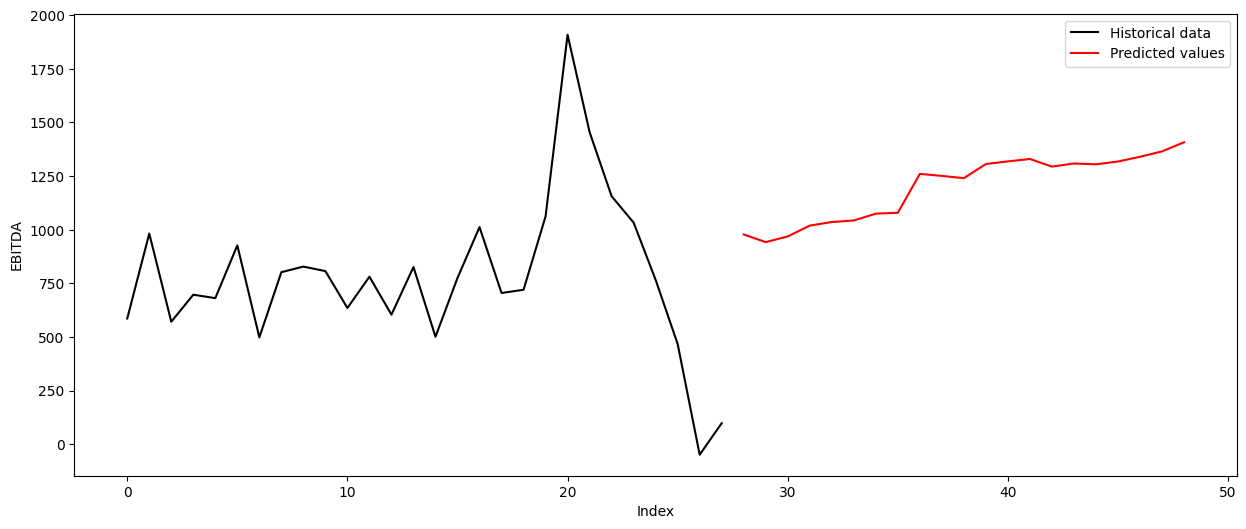

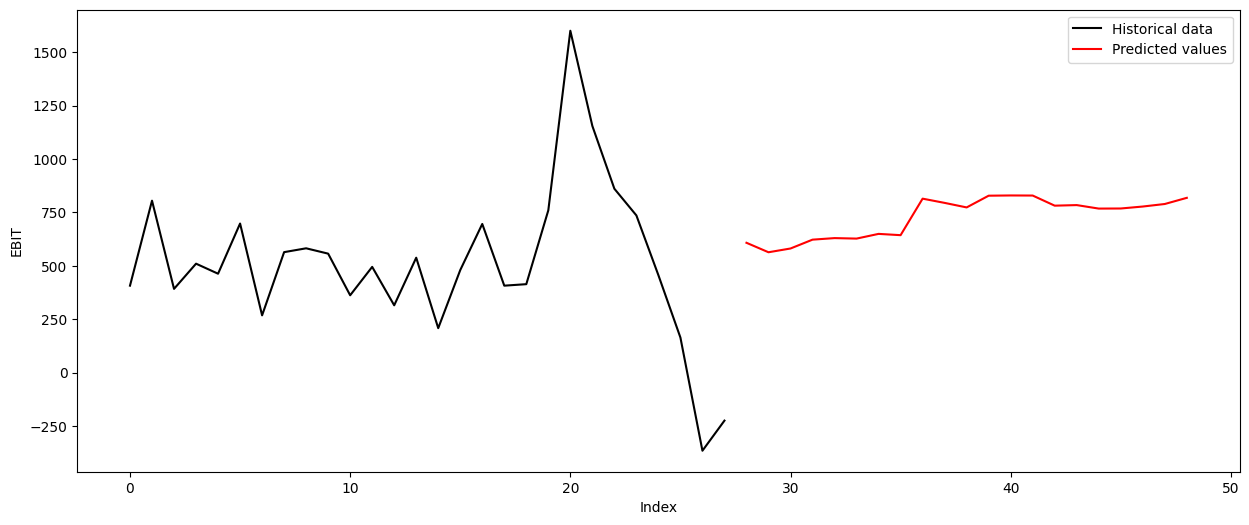

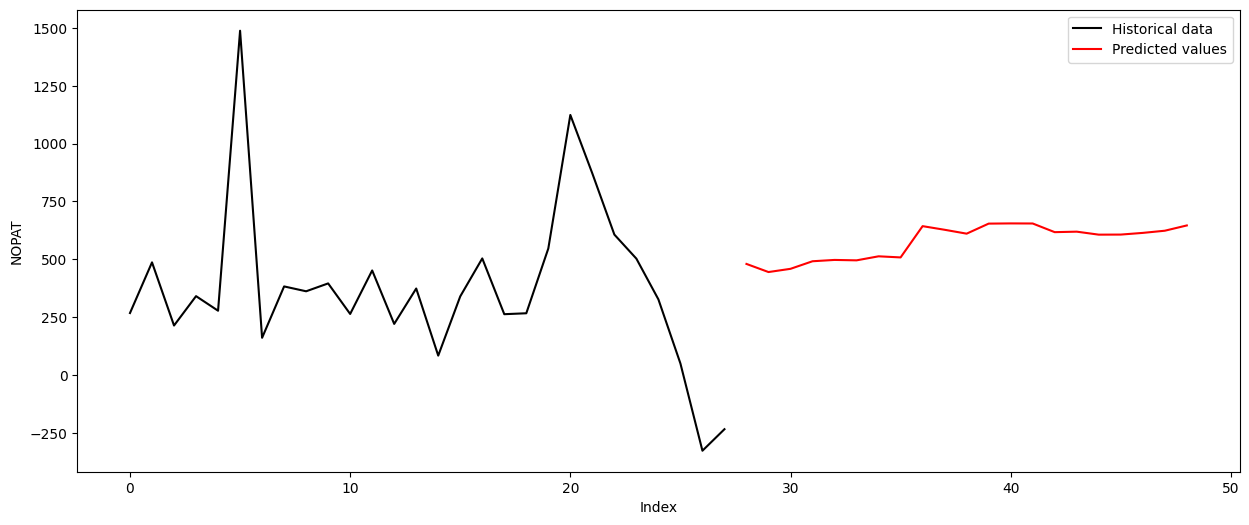

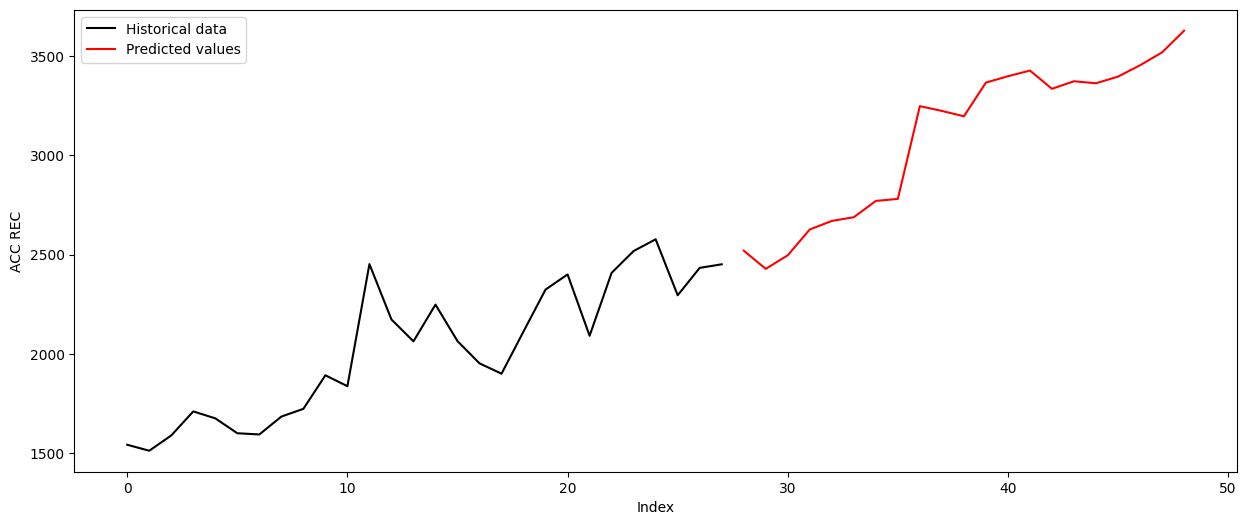

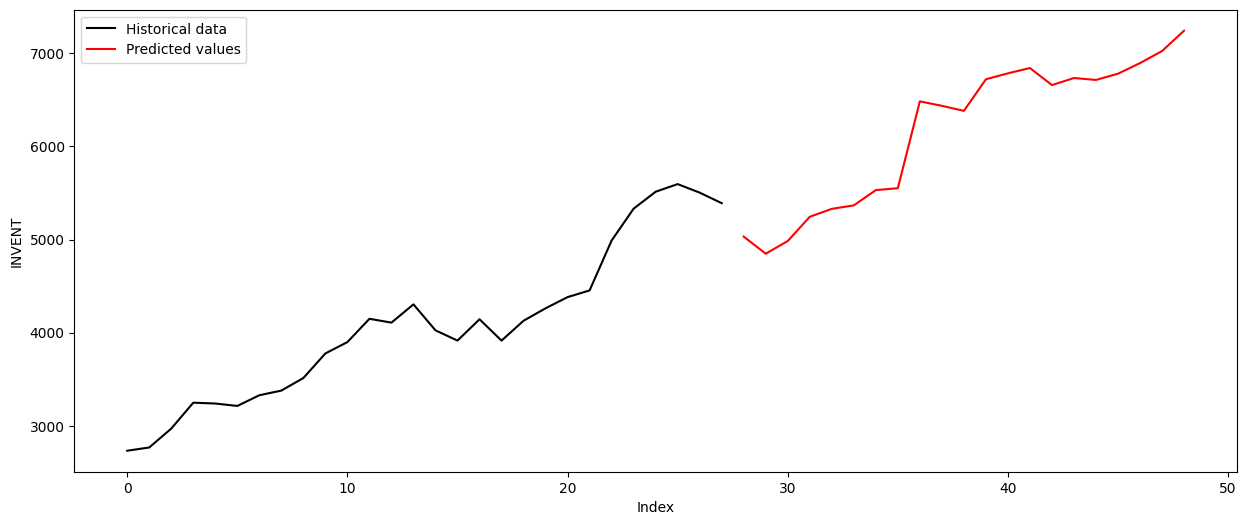

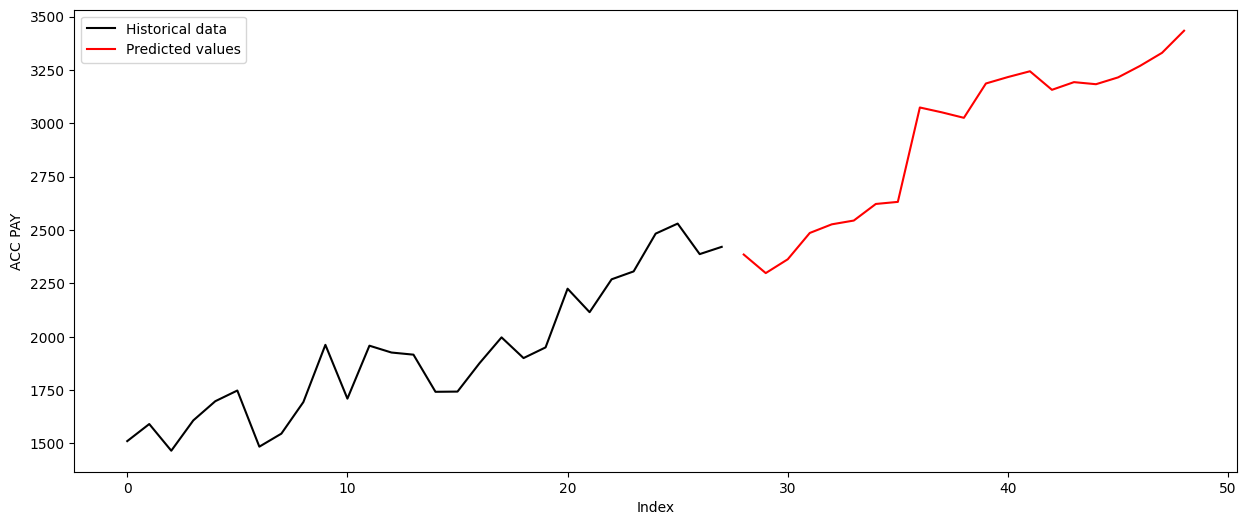

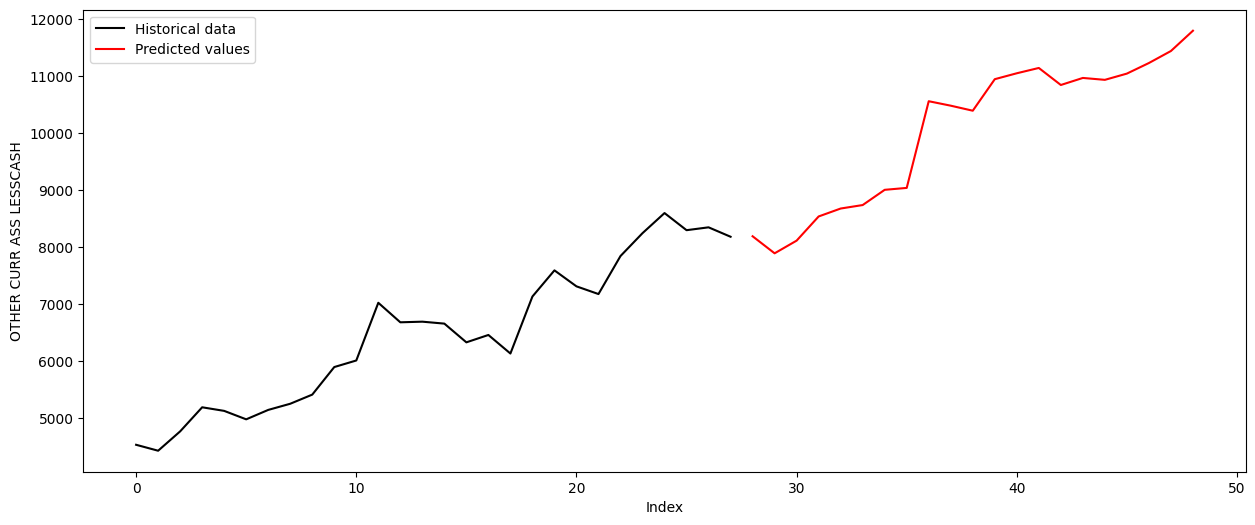

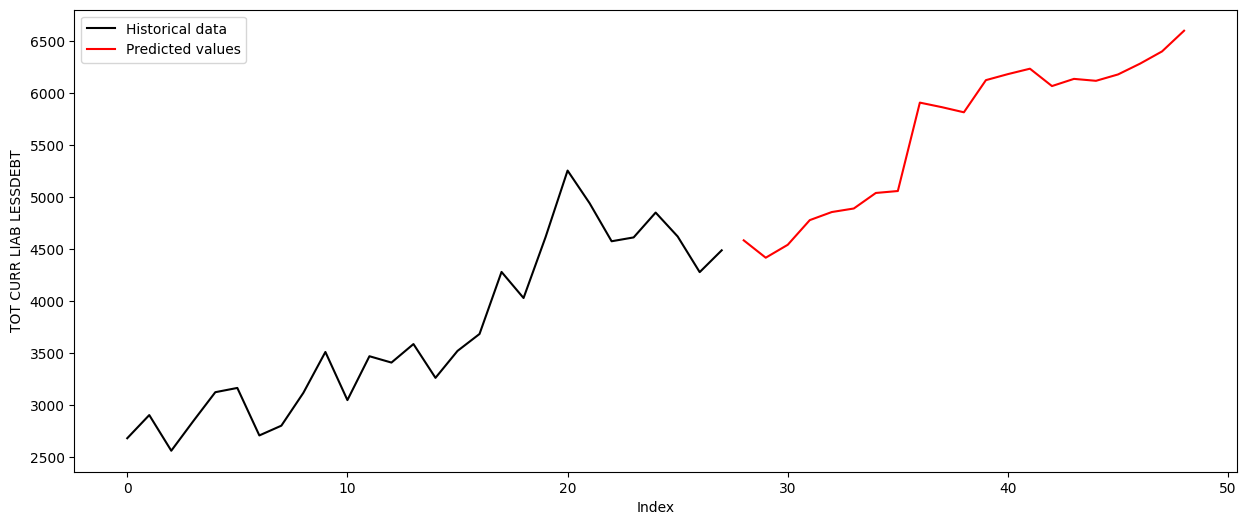

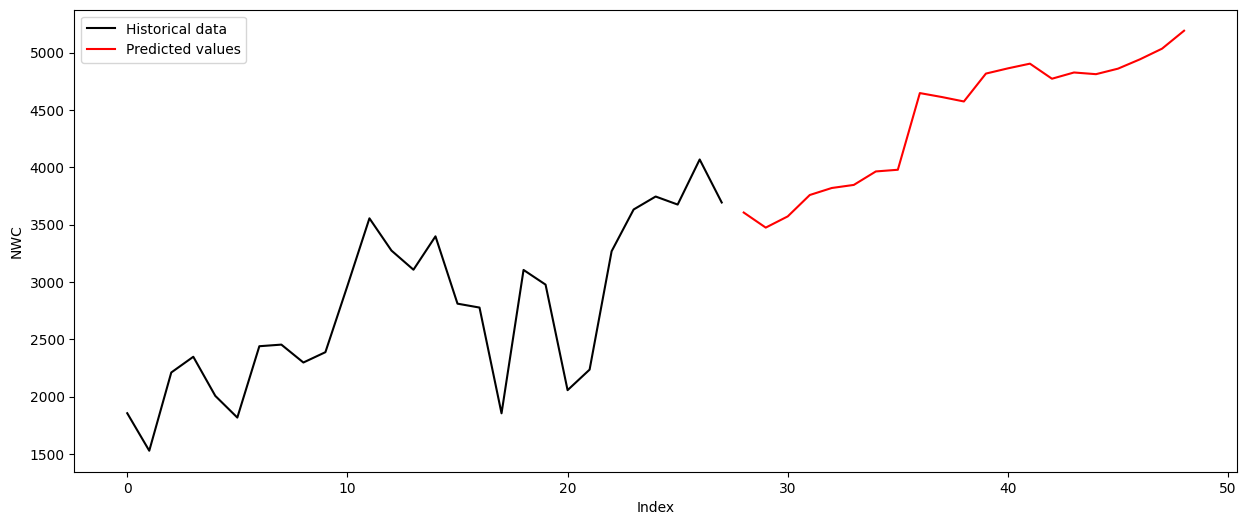

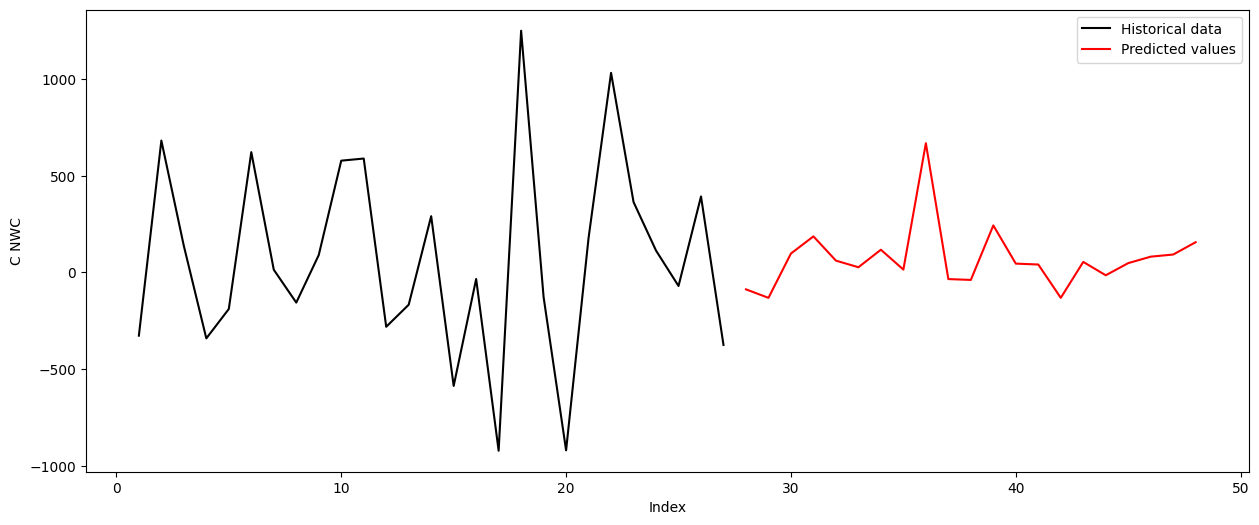

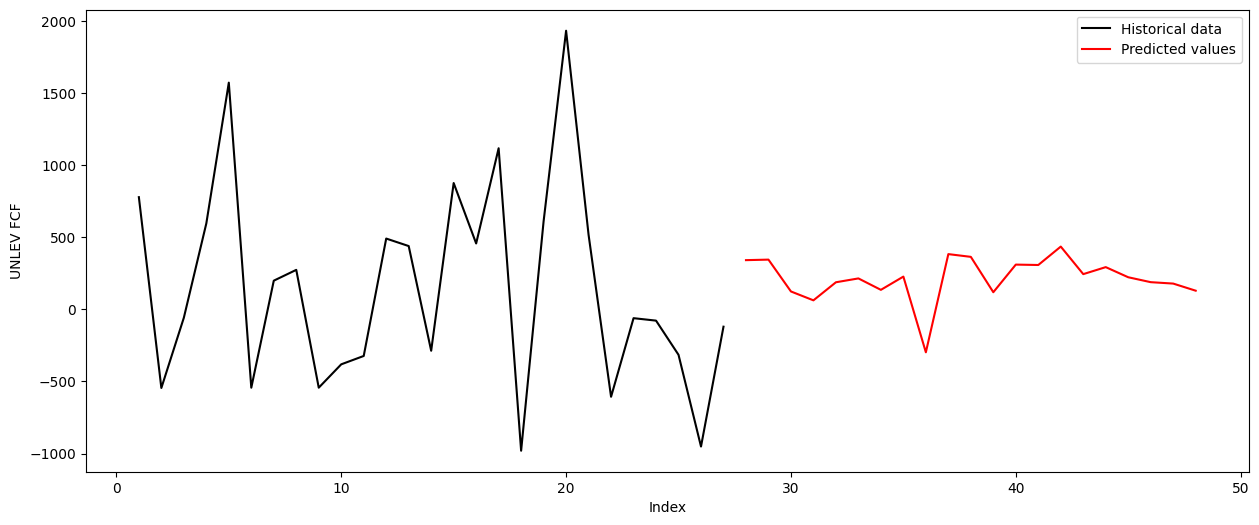

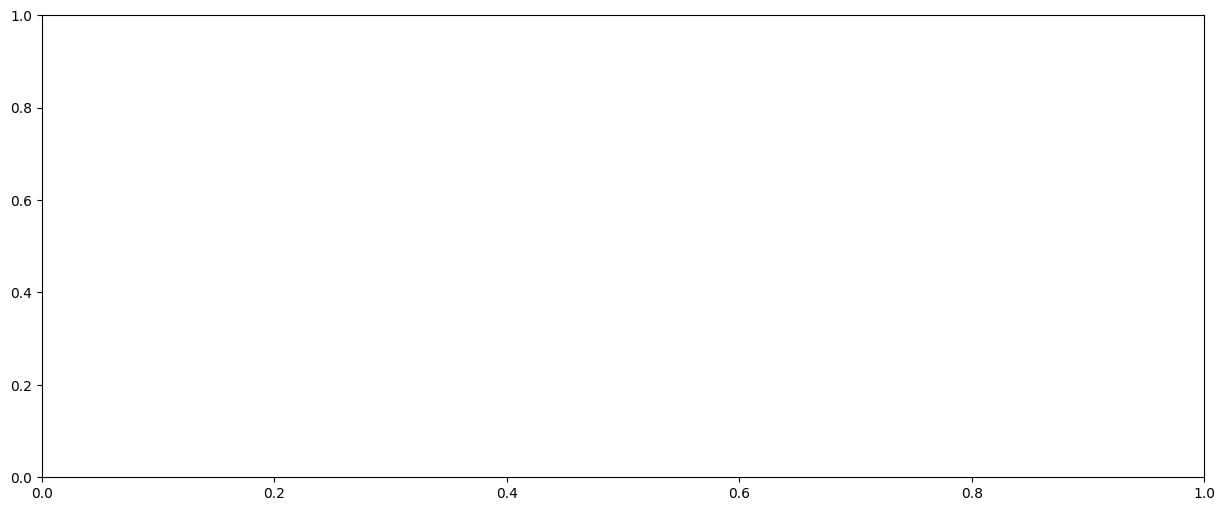

In [55]:
plot_hist_pred(data_filt, prediction)